# Stone Classifier

### Packge Load

In [1]:
import os
import cv2 as cv
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm

from tensorflow.keras import models, layers, losses, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications import VGG16, VGG19, Xception, InceptionResNetV2, InceptionV3
from tensorflow.keras.applications import MobileNet, MobileNetV2, NASNetLarge, NASNetMobile
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2, ResNet152V2

model_dict = {
    "vgg16": VGG16, 
    "vgg19": VGG19,
    "resnet50": ResNet50,
    "resnet101": ResNet101,
    "resnet152": ResNet152,
    "resnet50v2": ResNet50V2,
    "resnet101v2": ResNet101V2,
    "resnet152v2": ResNet152V2,
    "densenet121": DenseNet121,
    "densenet169": DenseNet169,
    "densenet201": DenseNet201,
    "mobilenet": MobileNet,
    "mobilenetv2": MobileNetV2,
    "xception": Xception,
    "inceptionresnetv2": InceptionResNetV2,
    "inceptionv3": InceptionV3, 
    "nasnetlarge": NASNetLarge,
    "nasnetmobile": NASNetMobile    
}

tf.random.set_seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Prepare Dataset

In [2]:
train_generator = ImageDataGenerator(rescale=1/255.)
valid_generator = ImageDataGenerator(rescale=1/255.)

IMG_SIZE = 299

train_loader = train_generator.flow_from_directory('./data/Train', target_size=(IMG_SIZE,IMG_SIZE), 
                                                 classes=['etc', 'chalcopyrite'],
                                                 class_mode='binary', shuffle=True, 
                                                )
print(f"학습용 황동석 이미지 수: {(train_loader.labels==1).sum()}")
print(f"학습용 황동석 아닌 이미지 수: {(train_loader.labels==0).sum()}\n")

valid_loader = valid_generator.flow_from_directory('./data/Test', target_size=(IMG_SIZE,IMG_SIZE), 
                                                 classes=['etc', 'chalcopyrite'],
                                                 class_mode='binary'
                                                )
print(f"검증용 황동석 이미지 수: {(valid_loader.labels==1).sum()}")
print(f"검증용 황동석 아닌 이미지 수: {(valid_loader.labels==0).sum()}")

Found 1657 images belonging to 2 classes.
학습용 황동석 이미지 수: 712
학습용 황동석 아닌 이미지 수: 945

Found 184 images belonging to 2 classes.
검증용 황동석 이미지 수: 79
검증용 황동석 아닌 이미지 수: 105


### Build Network

In [3]:
model_name = 'mobilenet'
base_model = model_dict[model_name](weights="imagenet", pooling="avg", include_top=False)
base_model.trainable = False
dropout = layers.Dropout(0.5)(base_model.output)
output = layers.Dense(1, activation='sigmoid')(dropout)
model = models.Model(base_model.inputs, output)

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])

/opt/conda/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 16s 1us/step


### Train Model

In [4]:
history = model.fit(train_loader, epochs=20, validation_data=valid_loader)
model.save(f'./checkpoints/{model_name}.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 52 steps, validate for 6 steps
Epoch 1/20
52/52 [==============================] - 13s 243ms/step - loss: 0.2537 - acc: 0.8992 - val_loss: 0.6939 - val_acc: 0.6141
Epoch 2/20
52/52 [==============================] - 8s 156ms/step - loss: 0.0754 - acc: 0.9777 - val_loss: 0.6661 - val_acc: 0.6196
Epoch 3/20
52/52 [==============================] - 8s 152ms/step - loss: 0.0464 - acc: 0.9897 - val_loss: 0.5919 - val_acc: 0.6739
Epoch 4/20
52/52 [==============================] - 8s 147ms/step - loss: 0.0413 - acc: 0.9916 - val_loss: 0.5729 - val_acc: 0.6848
Epoch 5/20
52/52 [==============================] - 10s 191ms/step - loss: 0.0308 - acc: 0.9952 - val_loss: 0.6791 - val_acc: 0.6250
Epoch 6/20
52/52 [==============================] - 10s 189ms/step - loss: 0.0261 - acc: 0.9940 - val_loss: 0.6505 - val_acc: 0.6522
Epoch 7/20
52/52 [==============================] - 8s 157ms/step - loss: 0.0251 - acc: 0.9940 - val_loss: 0.6437 

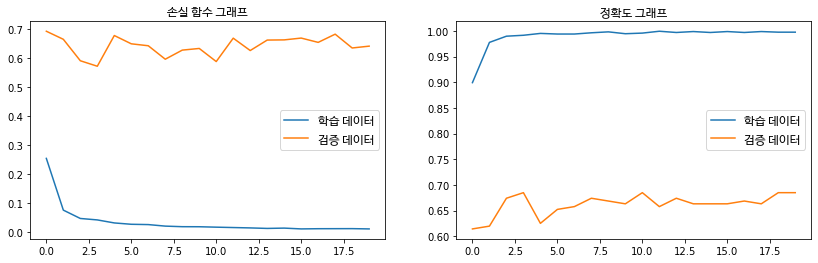

In [6]:
path = './fonts/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=path, size=12)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['학습 데이터', '검증 데이터'], loc=0, prop=fontprop)
plt.title("손실 함수 그래프", fontproperties=fontprop)

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['학습 데이터', '검증 데이터'], loc=0,  prop=fontprop)
plt.title("정확도 그래프", fontproperties=fontprop)

plt.savefig(f"./figures/{model_name}_training_graph.jpg")
plt.show()